In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2018/2018-10-16/recent-grads.csv'
path = "data/538-college-mayor-economic-guide.csv"
df = pd.read_csv(path)

### General Exploration Process

- find tops x across y. top 20 earnings across majors
- plot to see distribution of variables, distributions of summaries (dist of median)
- make counts and weighted sums. exmp: count(Major_category), count(Major_category by Total) = agg(major and sum its weights ) . Weighted count is only the name dyplr gives to that operation, not generally used in statistics. The process is actully suming the weights of each category ~~~
- how much do college graduates earn in general (histogram of salaries)
- are the high income salaries an acquate representation of the income one could expect from a major or is just due to **small sample size**
- comparing distribution by using boxplot, sorting one propertie to better see trends
- does this factor explain a lot of the variation, the outcome. 'exposure' -> 'outcome'
- look at the outliers
- more sample size, check if there is less variation, it should i think, if not one should take into account sample ~~~ if there is more variation in the low sample sizes than in the high sample sizes ...


In [3]:
df.columns

Index(['Rank', 'Major_code', 'Major', 'Total', 'Men', 'Women',
       'Major_category', 'ShareWomen', 'Sample_size', 'Employed', 'Full_time',
       'Part_time', 'Full_time_year_round', 'Unemployed', 'Unemployment_rate',
       'Median', 'P25th', 'P75th', 'College_jobs', 'Non_college_jobs',
       'Low_wage_jobs'],
      dtype='object')

In [66]:
x = df.groupby("Major_category", observed=True)["Median"].median().sort_values()
print(x)
print(type(x))
print(x.index.tolist())

Major_category
Psychology & Social Work               30000.0
Arts                                   30750.0
Humanities & Liberal Arts              32000.0
Education                              32750.0
Agriculture & Natural Resources        35000.0
Interdisciplinary                      35000.0
Industrial Arts & Consumer Services    35000.0
Health                                 35000.0
Communications & Journalism            35000.0
Law & Public Policy                    36000.0
Biology & Life Science                 36300.0
Social Science                         38000.0
Physical Sciences                      39500.0
Business                               40000.0
Computers & Mathematics                45000.0
Engineering                            57000.0
Name: Median, dtype: float64
<class 'pandas.core.series.Series'>
['Psychology & Social Work', 'Arts', 'Humanities & Liberal Arts', 'Education', 'Agriculture & Natural Resources', 'Interdisciplinary', 'Industrial Arts & Consumer Servi

In [63]:
y = (
    pd.read_csv(path)
    .groupby("Major_category", observed=True)["Median"]
    .median()
    .sort_values()
)

print(y)
print(type(y))
print(y.index.values)

Major_category
Psychology & Social Work               30000.0
Arts                                   30750.0
Humanities & Liberal Arts              32000.0
Education                              32750.0
Agriculture & Natural Resources        35000.0
Communications & Journalism            35000.0
Health                                 35000.0
Industrial Arts & Consumer Services    35000.0
Interdisciplinary                      35000.0
Law & Public Policy                    36000.0
Biology & Life Science                 36300.0
Social Science                         38000.0
Physical Sciences                      39500.0
Business                               40000.0
Computers & Mathematics                45000.0
Engineering                            57000.0
Name: Median, dtype: float64
<class 'pandas.core.series.Series'>
['Psychology & Social Work' 'Arts' 'Humanities & Liberal Arts' 'Education'
 'Agriculture & Natural Resources' 'Communications & Journalism' 'Health'
 'Industrial Arts &

In [69]:
def fct_reorder(df, factor, agg_by, agg_funct="median"):
    """
    Adds category ordering to a dataframe based on aggregated values of another column.\n
    It does not reorder the dataframe, but it changes the category order of the factor column.\n
    Helpfull for plotting functions that use the category order to sort the plot (df.boxplot()).\n
    Updates the df inplace.
    """

    # when using .index on a series or a df that has a CategoricalIndex it returns the actual type of CategoricalIndex that has info related to the order or not of the CategoricalIndex. When passed directly to pd.CategoricalDtype and ordered=True it will take the actual categorical values order. that why i'm getting an error when the factor argument is already a pd.CategoricalDtype in step 3. It is not assiging new categorical order but taking the already existing order. To fix it i had to call .index.tolist() to remove the information of the previous CategoricalIndex if any.

    # 1. Aggregate values for each category
    agg_category = df.groupby(factor, observed=True)[agg_by].agg(agg_funct)

    # 2. Get the order of the categories sorted by the aggregated values. FIXED
    category_order = agg_category.sort_values().index.tolist()

    # 3. Create a categorical dtype with categories sorted by mean values
    category_dtype = pd.CategoricalDtype(categories=category_order, ordered=True)

    # Assign the new category order to the 'category' column
    df[factor] = df[factor].astype(category_dtype)

    return df

### How Many majors per major category

- Description:

  Regular count of how many times Major_category appears as records since every record is a distinct Major.

  The actual transformations and aggregations are as follows:

  ```python
  (
    df.groupby(
      "Major_category", observed=True
    )["Major"]
    .nunique() # most accurate, but count() will produce the same since each Major is present once, this is by knowing the data
    .sort_values()
  )
  ```

  The simplified version is:

  ```python
     df["Major_category"].value_counts() # just count since each Major is present once, this is by knowing the data
  ```

  The verb is **count** since the variable being counted is a **categorical** one. Count its appearences.

  Count = sum of values weighted as 1.

- Consideraciones:

  - Tipo de operaciones que se pueden hacer sobre una variable categorica: contar, contar distintos
  - Ambas operaciones pueden ser intercambiables siempre que se sepa algo de la data inicialmente, o por exploracion. Si los valores son distintos, contar y contar distintos obviamente van a arrojar el mismo valor.
  - **Al agrupar por una categoria que pasa si existen nulls?** los contamos o no? para eso es el parametro observed?, si es true solo va a considerar los grupos cuya categoria esta definida.


[Text(0.5, 0, 'Number of Majors'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, '# Majors by Major Category')]

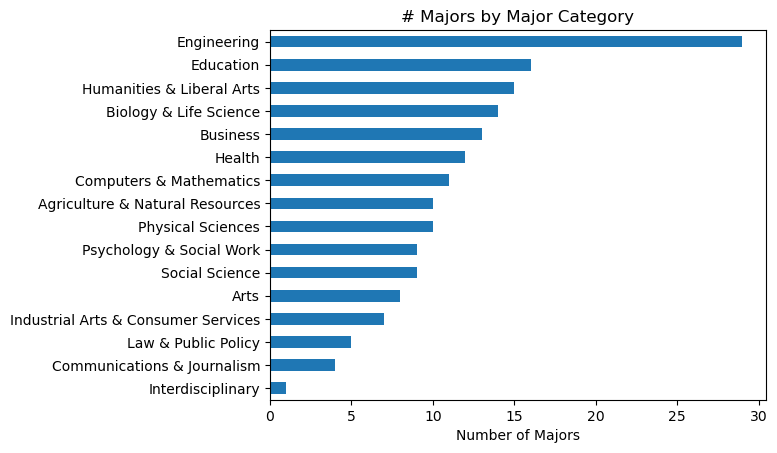

In [5]:
# observed=True: Future behavior. If True, will not try to infer the categories (will only use the observed categories)
# df.groupby("Major_category", observed=True).size().sort_values(ascending=False)
(
    df["Major_category"]
    .value_counts(ascending=True)
    .plot(kind="barh")
    .set(
        xlabel="Number of Majors",
        ylabel="",
        title="# Majors by Major Category",
    )
)

### How many grads per major category?

- Description:

  The kind of problem being solved is: **Aggregation by Category**.

  Se va a reducir el dataframe via aggregation. **Grouping and Reducing**.

  - the kind of aggregation will depend on the variable being used for agregation.
  - you group by something, and agregate by something (could be the same variable, for counts ~~ giving you the frequency of ocurrence, or by other variable)
  - if the variable being aggregated is categorical, then a variation of counting is what can be done. Or, just listing the values.
  - if the variable being aggregates is numerical, then every numerical operation

  It is a hasle to accomplish something that simple as formating an axis in matplotlib, so i wont do it. But this is what it takes:

  ```python
  def custom_formatter(x, pos):
      "The two args are the value and tick position"
      return "{:0.1f}".format(x)

  formatter = ticker.FuncFormatter(custom_formatter)

  ax = df['numeric_column'].plot(kind="barh")
  ax.xaxis.set_major_formatter(formatter)
  ```


[Text(0.5, 0, 'Total Grads'),
 Text(0.5, 1.0, 'Total Grads by Major Category'),
 Text(0, 0.5, '')]

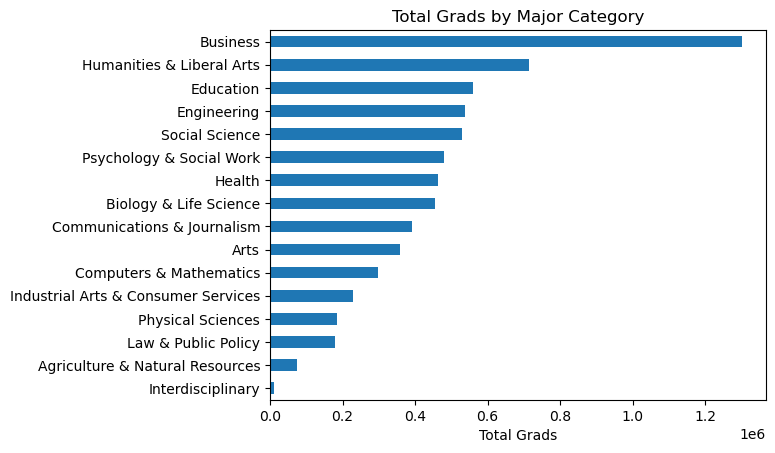

In [6]:
(
    df.groupby("Major_category", observed=True)["Total"]
    .sum()
    .sort_values()
    .plot(kind="barh")
    .set(
        xlabel="Total Grads",
        title="Total Grads by Major Category",
        ylabel="",
    )
)

- Hay mas graduados de negocios que de ingenieria, pero hay mas carreras de ingenieria que de  
   negocios.

> Hay mas graduados de negocios porque en ingenieria no terminan la carrera o porque no hay tantos estudiantes de ingenieria/hay mas estudiantes de negocios que de ingenieria?


### What is the distribution of graduate students across major categories?

- Consideraciones:

  This works withough warnings

  ```python
  (
      df.pipe(fct_reorder, "Major_category", "Total")
      .boxplot(column="Total", by="Major_category", vert=False)
      .set(xlabel="Total Grads", title="Boxplot of Total Grads by Major Category")
  )
  ```

  But when using _by_ argument in plot kind box the return type is a Series so we can't use _set_ method to set the labels which is kind of weird, but this is the behavior. De hecho ya vi la documentacion de pandas boxplot y asi es xd (o creo que era la docu de matplotlib)

  ```python
  (
      df.pipe(fct_reorder, "Major_category", "Total")
      .plot(kind="box", column="Total", by="Major_category", vert=False)
      .set(xlabel="Total Grads", title="Boxplot of Total Grads by Major Category")
  )
  ```

  Parece que los metodos plot.plot_type tienen mayor mantenimiento, creo que los usare mejor. Además ya analizé que se comporta mejor el .boxplot() cuando se hace agregaciones ya que por defecto si ordena las categorias, en comparacion con el resto de variantes del mismo metodo. Aunque usar directamente el metodo oculta el hecho de que se esta haciendo un plot, gramaticalmente .plot. o .plot(kind) se evidencia que se va a plotear. En fin, cosas de pandas.

  Ademas el boxplot de pandas al agrupar usando by coloca un titulo por defecto siempre que no se puede quitar en el mismo metodo. [detail](https://stackoverflow.com/questions/66446314/change-the-grouped-title-not-usual-plot-title-of-a-pandas-boxplot)

  **La logica detras de todo esto es solo usar method chaining.**

- Otra cosa que me di cuenta:

  al poner una coma al final de una lista de argumentos, black lo formatea hacia abajo ((detalles)[https://black.readthedocs.io/en/stable/the_black_code_style/current_style.html#the-magic-trailing-comma]).

  Asi que esto:

  ```python
  (
      df.pipe(fct_reorder, "Major_category", "Total")
      .boxplot(column="Total", by="Major_category", vert=False)
      .set(
          xlabel="Total Grads",
          ylabel="",
          title="Distribution of Grad Students",
      )
  )
  ```

  se podria convertir en esto:

  ```python
  df.pipe(
      fct_reorder,
      "Major_category",
      "Total", # <--- final comma
  ).boxplot(
      column="Total",
      by="Major_category",
      vert=False, # <--- final comma
  ).set(
      xlabel="Total Grads",
      ylabel="",
      title="Distribution of Grad Students", # <--- final comma
  )
  ```


[Text(0.5, 0, 'Total Grads'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Distribution of Grad Students by Major category')]

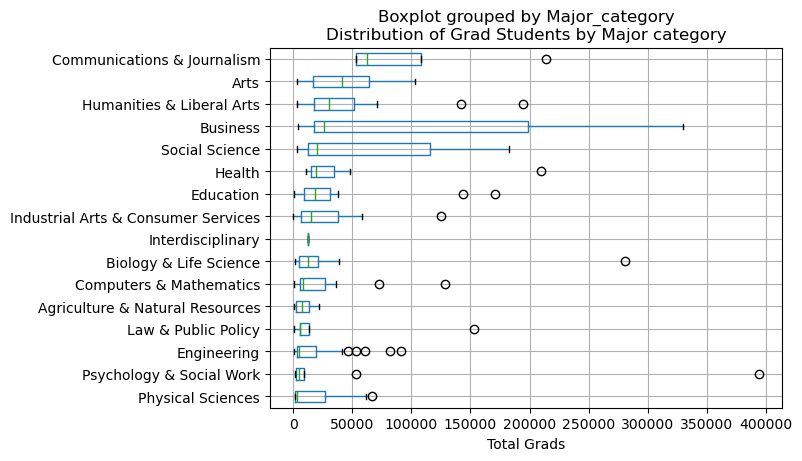

In [24]:
df.pipe(
    fct_reorder,
    "Major_category",
    "Total",
).boxplot(
    column="Total",
    by="Major_category",
    vert=False,
).set(
    xlabel="Total Grads",
    ylabel="",
    title="Distribution of Grad Students by Major category",
)

I've always have this concern:

Differences Between "By" and "Per"

**By**:

- Indicates the method, agent, or means through which something is done.
- Used to denote a classification or grouping.
- Example: "Grouped by category" means that items are organized based on their categories.

**Per**:

- Indicates a rate or ratio.
- Often used to express frequency or distribution.
- Example: "Per day" means for each day or according to each day.

Are They Interchangeable?

In these specific contexts, "by" and "per" are used in slightly different ways to convey the organization and distribution of data. However, their intended meanings are quite similar and can often be used interchangeably without significantly changing the interpretation. Both versions effectively convey that you are calculating the median number of graduates for each major within a given major category.

Best: Median of --Grads per Major-- by --Major Category--  
--Grads per Major--: por cada major hay una cantidad de graduados. La media se aplica sobre los valores numericos, Grads. Major | Grads (2 variables del dataset)
--Major Category--: antes de calcular la media, segmenta los majors.

Ahora, agrupando la primera parte --Median of Grads--  
Decir **la media de graduados** ya implica que hay varios registros de cuantos graduados hay. Pero la **media esta asociada a una categoria** siempre. No es lo mismo sacar la media considerando Major | Grad, que sacar la media de Year | Grad.

Pero la **media y cualquier agregacion esta asociada a un registro unico** siempre. No es lo mismo sacar la media considerando Major | Grad, que sacar la media de Year | Grad.

Podria decirse Year | Grad by Major Catebory e implicaria lo mismo? No.

En general, una agregación se hace sobre una variable numerica con respecto a una variable categorica, a cada registro de esa variable categorica.

En si una agregacion es una operacion sobre numeros, pero en un contexto real al momento de comunicar algo que tenga sentido (una description de ALGO) implica que el registro del cual viene cada valor es **unico**.

- Ej. La media de edades. De que registros? si se repite el registro igual se considera para calcular? obvio no.

Por eso, tidydata tiene registros unicos, o como tal los registros, asi sean multiindex lo son porque deberian buscar ser unicos.

en el caso de **Median of --Grads per Major-- by --Major Category--** per _Major_ viene a ser el index, el que va a indicar el registro unico sobre el cual se esta agregando(median) la variable numerica(grads). **Major Category** es solo una variable adicional sobre ese registro unico, sigue siendo un registro unico, y esa variable solo esta siendo usada para segmentar la operacion.

Si pensamos en economia de lenguaje, podria simplificarse **Median Grads per Major by Major Category** en **Median Grads by Major Category**, considerando que la mediana se esta sacando sobre todos los registros sobre los que se esta segmentando.

Pero no siempre va a significar lo mismo, porque decir **grads per YEAR by major category** no es lo mismo que **grads per MAJOR by major category**.

The simplified version **implies** that the median is calculated from the total grads across **majors**. **WRONG**

the above was wrong because one could have (considering already agregated majors):  
Grads | Major Category  
100 | X  
150 | Y  
320 | Z  
Median Grads per Major Category

Since using by or per can be interchangeable and interpreted as the same and not necesarily as grouping **Median Grads per Major Category** no estaria representando lo mismo que **Median Grads per Major by Major Category**. Va a depender del shape de la data, y que transformaciones y agregaciones se han hecho previamente. En el ejemplo anterior se hizo una agregacion ya a los grads sumando todos los majors por major category.

and it will be diferent a different media than if having the extra column Major, in wich case

En resumen:

- definir sobre que variable numerica se esta agregando (SIEMPRE)
- definir la variable categorica que viene asociada a la agregacion (NO Necesariamente): esto porque va a depender de como esta la data cuando se esta agregando. (NO) esto debe ser (SIEMPRE) y la variable categorica asociada debe ser el indice que representa a los registros para la agregacion.
- definir si se esta haciendo la agregacion segmentando o no (OK): para mi convencion siempre le voy a poner "by" cuando se haga una segmentacion.
- si se segmenta y la variable que se esta agregando es una subcategoria directa sobre la variable que se usa para segmentar, se puede considerar omitir la variable categorica asociada a la agregacion. (NO NECESARIAMENTE): esto porque va a depender de como esta la data cuando se esta agregando

Creo que en sí, para que tenga sentido al comunicar, la agregacion tiene que estar asociada a una variable que indique el registro unico sobre el cual se esta haciendo la agregacion (**Median of #VAR per**). Este registro unico puede estar definido en base uno o multiples variables (**Median of #VAR per VAR1** ej **Median of grads per major**, **Median of grads per major per year**, **Median of grads per major per year per gender**) en cual caso en el que sean multiples variables la agregacion seria una **combinacion** de estas. Pero entonces ya el limite es qué tan interpretable es para el ser humano. Como tal, las agregaciones al final estan restringidas a un conjunto de **indices** que hacen unicos a los registros de la variable sobre la cual se esta agregando. En el ejemplo anterior (abajo lo vuelvo a poner) se entiende que el indice es Major_category y sobre ese se va a realizar la agregacion.

Grads | Major Category  
100 | X  
150 | Y  
320 | Z  
Median Grads per Major Category

Entonces si, una agregacion debe tener una variable numerica y una variable "categorica" (puede ser un numero, como un año, pero se considera categoria) que represente un indice unico de cada registro sobre el cual se esta haciendo la agregacion.

PER: indica la variable indice (SIEMPRE)  
BY: indica la variable sobre la que se va a segmentar antes de la agregacion (SOLO SI HAY SEGMENTACION)

Ahora, este indice (per) puede venir de agregaciones previas como en el caso de arriba, pero esto tiene que estar totalmente claro para el lector. El lector debe entender de que data se esta hablando, de la original, de una agregada, la combinacion de valores de la data original? se esta segmentando?


[Text(0.5, 1.0, 'Median of Grads per Major by Major Category')]

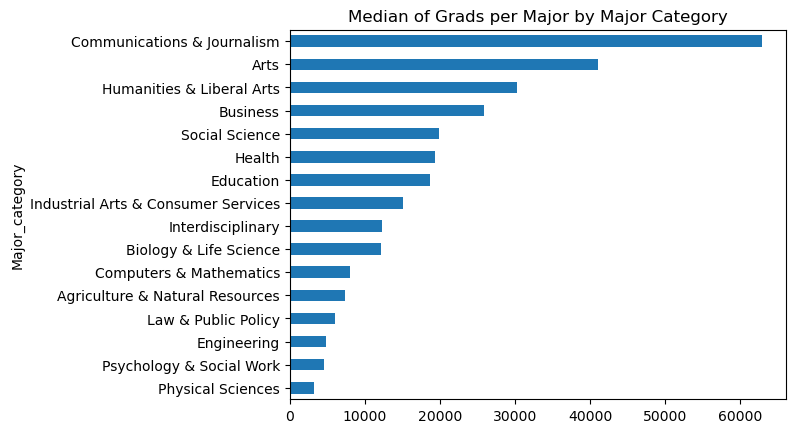

In [33]:
df.groupby(
    "Major_category",
    observed=True,
)["Total"].median().sort_values().plot.barh().set(
    title="Median of Grads per Major by Major Category"
)

La mediana de graduados sigue una distribucion exponencial? log normal?

Si la distribucion tiene pocas observaciones podria hacerse un scatter plot.


[Text(0.5, 0, 'Graduates'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Total Grads per Major per Major Category')]

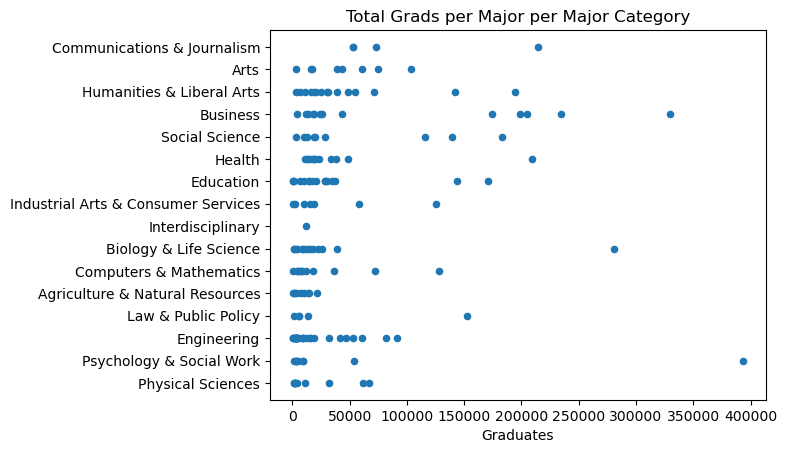

In [20]:
df.pipe(
    fct_reorder,
    "Major_category",
    "Total",
).sort_values(
    "Major_category",
).plot.scatter(
    x="Total",
    y="Major_category",
).set(
    xlabel="Graduates",
    ylabel="",
    title="Total Grads per Major per Major Category",
)

- plt.scatter x, y pueden ser numericos o categoricos(str-ish) pero el color si o si tiene que ser numerico, sino tira error (aunque igual grafica algo)

  ```python
  dft = pd.DataFrame(
      [["x", "aa", 4], ["z", "bb", 2], ["m", "cc", 1], ["y", "tt", 1], ["w", "dd", 2]],
      columns=["species", "cat", "length"],
  )

  # no tira error
  dft.plot.scatter(x="length", y="species", c="length")

  # tira error pero grafica 'algo'
  dft.plot.scatter(x="length", y="length", c="species")
  ```

- Nota: black formatter en notebooks cuando se guarda formatea a 2 indentaciones, pero luego se vuelve a 4 y ya no se xd.


### Top majors with most graduates


In [39]:
df.nlargest(columns="Total", n=10)[["Major_category", "Major", "Total", "Median"]]

,Major_category,Major,Total,Median
145,Psychology & Social Work,PSYCHOLOGY,393735.0,31500
76,Business,BUSINESS MANAGEMENT AND ADMINISTRATION,329927.0,38000
123,Biology & Life Science,BIOLOGY,280709.0,33400
57,Business,GENERAL BUSINESS,234590.0,40000
93,Communications & Journalism,COMMUNICATIONS,213996.0,35000
34,Health,NURSING,209394.0,48000
77,Business,MARKETING AND MARKETING RESEARCH,205211.0,38000
40,Business,ACCOUNTING,198633.0,45000
137,Humanities & Liberal Arts,ENGLISH LANGUAGE AND LITERATURE,194673.0,32000
78,Social Science,POLITICAL SCIENCE AND GOVERNMENT,182621.0,38000


Pshychology has the most graduate students. But as seen above, its category, Psychology & Social Work, has one of the least graduates compared to other categories (in total and in median of its category). Psychology is an outlier of its own category (also seen and identified now in the boxplot). There're fewer grads in other majors in the Psychology & Social Work category compared to Psychology, probably more related to social work? No, see bellow


In [42]:
df[df["Major_category"] == "Psychology & Social Work"].sort_values(
    "Total", ascending=False
)[["Major", "Total", "Median"]]

,Major,Total,Median
145,PSYCHOLOGY,393735.0,31500
151,SOCIAL WORK,53552.0,30000
155,MISCELLANEOUS PSYCHOLOGY,9628.0,30000
156,HUMAN SERVICES AND COMMUNITY ORGANIZATION,9374.0,30000
171,COUNSELING PSYCHOLOGY,4626.0,23400
70,INDUSTRIAL AND ORGANIZATIONAL PSYCHOLOGY,3014.0,40000
169,EDUCATIONAL PSYCHOLOGY,2854.0,25000
170,CLINICAL PSYCHOLOGY,2838.0,25000
91,SOCIAL PSYCHOLOGY,1386.0,36000


Also, across psychology **INDUSTRIAL AND ORGANIZATIONAL PSYCHOLOGY** is the one that has the highest median earnings across its cateory.


In [43]:
df.head()

,Rank,Major_code,Major,Total,Men,Women,Major_category,ShareWomen,Sample_size,Employed,...,Part_time,Full_time_year_round,Unemployed,Unemployment_rate,Median,P25th,P75th,College_jobs,Non_college_jobs,Low_wage_jobs
0,1,2419,PETROLEUM ENGINEERING,2339.0,2057.0,282.0,Engineering,0.120564,36,1976,...,270,1207,37,0.018381,110000,95000,125000,1534,364,193
1,2,2416,MINING AND MINERAL ENGINEERING,756.0,679.0,77.0,Engineering,0.101852,7,640,...,170,388,85,0.117241,75000,55000,90000,350,257,50
2,3,2415,METALLURGICAL ENGINEERING,856.0,725.0,131.0,Engineering,0.153037,3,648,...,133,340,16,0.024096,73000,50000,105000,456,176,0
3,4,2417,NAVAL ARCHITECTURE AND MARINE ENGINEERING,1258.0,1123.0,135.0,Engineering,0.107313,16,758,...,150,692,40,0.050125,70000,43000,80000,529,102,0
4,5,2405,CHEMICAL ENGINEERING,32260.0,21239.0,11021.0,Engineering,0.341631,289,25694,...,5180,16697,1672,0.061098,65000,50000,75000,18314,4440,972


### Earnings across categories


<Axes: title={'center': 'Median'}, ylabel='Major_category'>

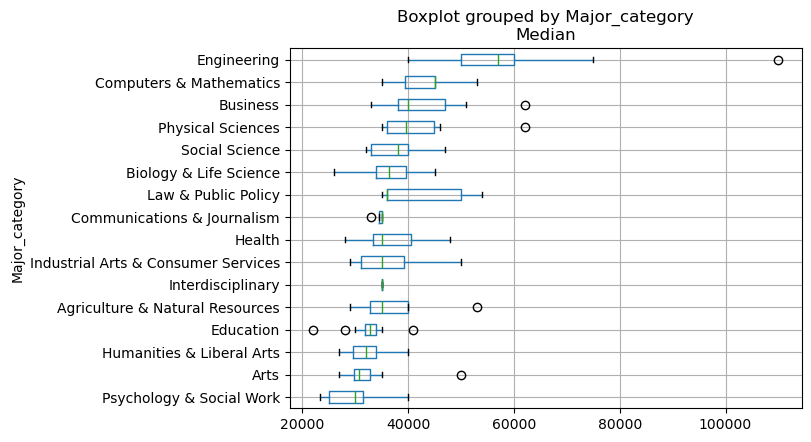

In [68]:
df.pipe(fct_reorder, "Major_category", "Median").boxplot(
    column="Median", by="Major_category", vert=False
)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Rank                  173 non-null    int64   
 1   Major_code            173 non-null    int64   
 2   Major                 173 non-null    object  
 3   Total                 172 non-null    float64 
 4   Men                   172 non-null    float64 
 5   Women                 172 non-null    float64 
 6   Major_category        173 non-null    category
 7   ShareWomen            172 non-null    float64 
 8   Sample_size           173 non-null    int64   
 9   Employed              173 non-null    int64   
 10  Full_time             173 non-null    int64   
 11  Part_time             173 non-null    int64   
 12  Full_time_year_round  173 non-null    int64   
 13  Unemployed            173 non-null    int64   
 14  Unemployment_rate     173 non-null    float64 
 15  Median

<Axes: ylabel='Major'>

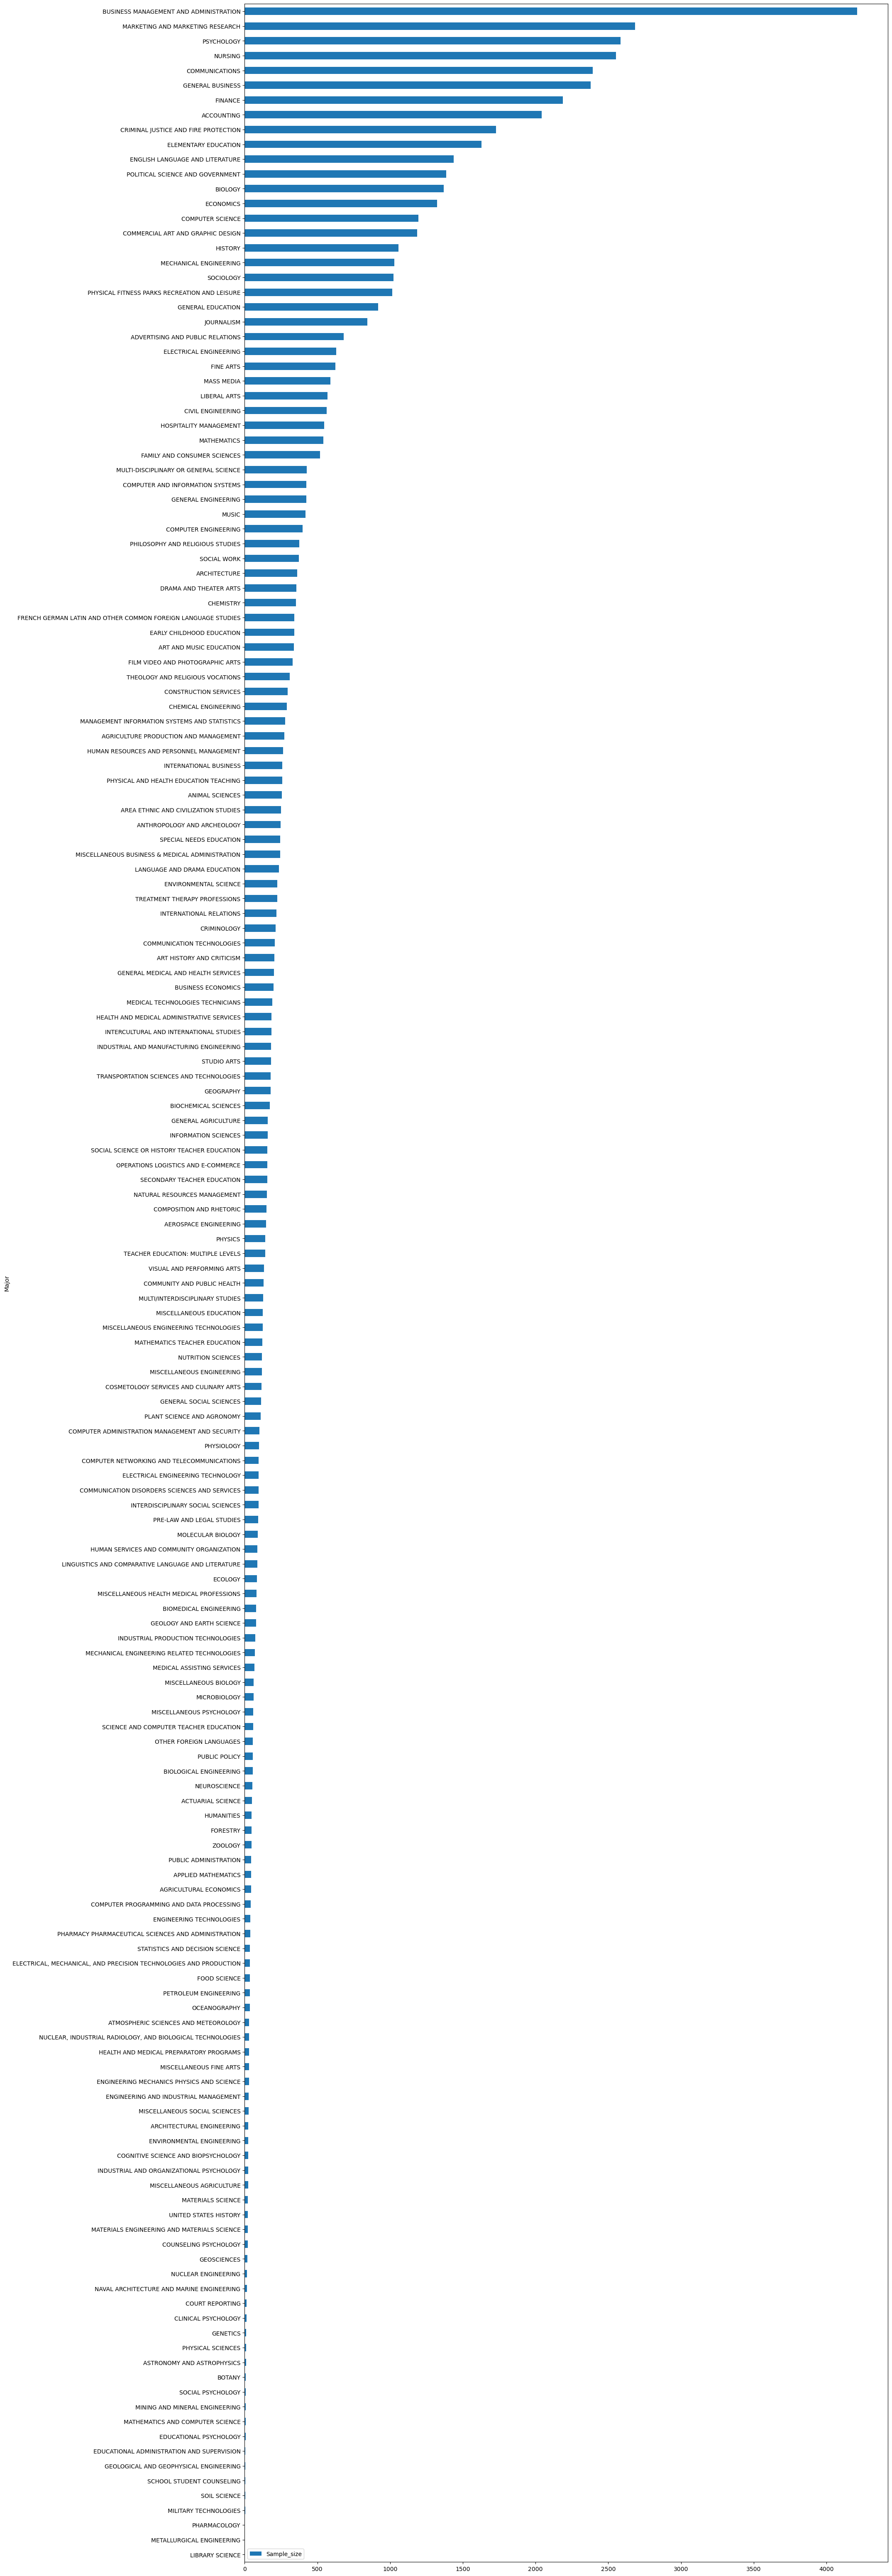

In [ ]:
df.sort_values("Sample_size").plot.barh(x="Major", y="Sample_size", figsize=(20, 80))

En matplotlib no hay una opcion para especificar el orden de los elementos en los ejes. .boxplot en pandas es el unico (?) metodo que al pasarle by ordena el eje en base a los indices. en general como se esta usando matplotlib otros metodos de pandas no hacen eso, scatter por ejemplo, ya que en general plotean en el orden en que aparecen los elementos.


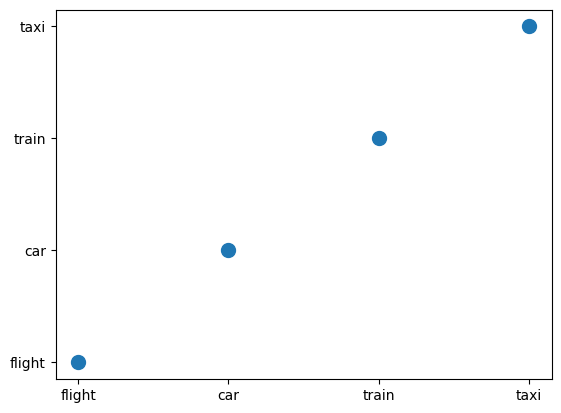

In [83]:
import matplotlib.pyplot as plt

travel = ["flight", "car", "train", "taxi"]
price = ["flight", "car", "train", "taxi"]

plt.scatter(travel, price, s=100)
plt.show()